# Evaluate

* Before you get started, please make sure your `vocab.json` and `config.max_answers` corresponds to your model's parameters to be evaluated.

## Define our evaluation function:

In [4]:
import sys
import os.path
import math
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from tqdm import tqdm

import config
import data
import model
import utils
import train

def evaluate(net, loader, optimizer, tracker, prefix='', epoch=0):
    """ Run an epoch over the given loader """
    net.eval()
    tracker_class, tracker_params = tracker.MeanMonitor, {}
    answ = []
    idxs = []
    accs = []

    tq = tqdm(loader, desc='{} E{:03d}'.format(prefix, epoch), ncols=0)
    loss_tracker = tracker.track('{}_loss'.format(prefix), tracker_class(**tracker_params))
    acc_tracker = tracker.track('{}_acc'.format(prefix), tracker_class(**tracker_params))

    log_softmax = nn.LogSoftmax(dim=0).cuda()
    for v, q, a, idx, q_len in tq:
        var_params = {
            'requires_grad': False,
        }
        v = Variable(v.cuda(non_blocking=True), **var_params)
        q = Variable(q.cuda(non_blocking=True), **var_params)
        a = Variable(a.cuda(non_blocking=True), **var_params)
        q_len = Variable(q_len.cuda(non_blocking=True), **var_params)

        out = net(v, q, q_len) # output of the net

        nll = -log_softmax(out)
        loss = (nll * a / 10).sum(dim=1).mean()
        acc = utils.batch_accuracy(out.data, a.data).cpu()

        # store information about evaluation of this minibatch
        _, answer = out.data.cpu().max(dim=1)
        answ.append(answer.view(-1))
        accs.append(acc.view(-1))
        idxs.append(idx.view(-1).clone())
        
        loss_tracker.append(loss.item())
        # acc_tracker.append(acc.mean())
        for a in acc:
            acc_tracker.append(a.item())
        fmt = '{:.4f}'.format
        tq.set_postfix(loss=fmt(loss_tracker.mean.value), acc=fmt(acc_tracker.mean.value))

    answ = list(torch.cat(answ, dim=0))
    accs = list(torch.cat(accs, dim=0))
    idxs = list(torch.cat(idxs, dim=0))
    return answ, accs, idxs


## Load your model:

In [3]:
val_loader = data.get_loader(val=True)

# Load model
pretrained_model_path = 'logs/2021-07-10_13:44:34.pth'
log = torch.load(pretrained_model_path) # load from disk
if log is not None: print("Successfully loaded pretrained model from {}.".format(pretrained_model_path))
tokens = len(log['vocab']['question']) + 1 # retrieve the number of output layer nodes
print(tokens)
net = nn.DataParallel(model.Net(val_loader.dataset.num_tokens)).cuda() # define the `net`
net.load_state_dict(log['weights']) # load parameters into `net`

optimizer = optim.Adam([p for p in net.parameters() if p.requires_grad])
tracker = utils.Tracker()

Successfully loaded pretrained model from logs/2021-07-10_13:44:34.pth.
5201


## Evaluate the model now:

In [10]:
answ, accs, idxs = evaluate(net, val_loader, optimizer, tracker, prefix='val', epoch=0)

val E000: 100% 168/168 [00:18<00:00,  9.03it/s, acc=0.3892, loss=2.5177]


## Generate a result JSON file for later visualization.

In [43]:
import numpy as np
import json

print("Average accuracy:", np.mean(accs))

with open('data/questions/val.json', 'r') as fd:
   questions_json = json.load(fd)

with open('vocab.json', 'r') as fd:
   vocab = json.load(fd)
   answ_dict = vocab['answer']

question_ids = [question['question_id'] for question in questions_json['questions']]
results = []

for i in range(len(idxs)):
   results.append({"answer": list(answ_dict.keys())[list(answ_dict.values()).index(answ[i].item())], "question_id": question_ids[idxs[i]]})

with open('result.json', 'w') as fd:
   json.dump(results, fd)

21435
21435
Average accuracy: 0.3891999
21435
tensor(21391)


## Visualize it!

loading VQA annotations and questions into memory...
0:00:00.263475
creating index...
index created!
Loading and preparing results...     
DONE (t=0.03s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 38.92

Per Question Type Accuracy is the following:
how many : 28.32
what is the : 19.93
is this a : 58.43
what is the man : 34.61
does the : 65.53
how : 6.12
is this : 56.67
what kind of : 25.44
is the : 61.79
none of the above : 39.45
are : 64.72
is it : 66.99
are the : 64.13
what : 22.32
is : 61.35
why is the : 2.33
where are the : 14.43
are these : 67.43
was : 47.62
what is : 16.99
what color : 23.38
why : 4.50
what is in the : 23.73
what color is the : 33.89
what are : 21.83
what is this : 34.78
what are the : 23.65
what is the person : 42.22
what color are the : 26.49
who is : 18.80
what color is : 28.43
which : 23.73
is the person : 64.09
does this : 59.38
has : 59.51
where is the : 10.1

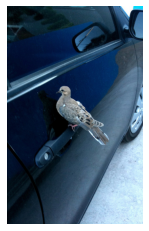

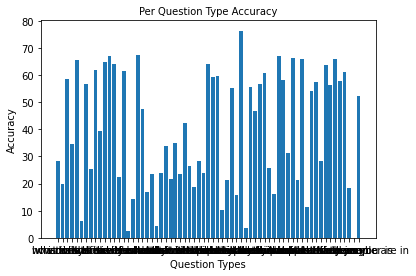

In [45]:
"""
input: results file (generated by your model), annotations file, questions file
output: evalAnsType, evalQuesType, evalQA, accuracy
"""
import sys
dataDir = '.'
sys.path.insert(0, '%s/PythonHelperTools/vqaTools' %(dataDir))
sys.path.insert(0, '%s/PythonEvaluationTools/vqaEvaluation' %(dataDir))
from vqa import VQA
from vqaEval import VQAEval
import matplotlib.pyplot as plt
import skimage.io as io
import json
import random
import os

# set up file names and paths
dataDir		='./data'
train_test_val = 'val'
dataSubType = 'train2014' if train_test_val == 'train' else 'val2014'
annFile     = '%s/annotations/%s.json'%(dataDir, train_test_val)
quesFile    = '%s/questions/%s.json'%(dataDir, train_test_val)
# annFile     = '%s/results/val_fake_annotations.json'%(dataDir) # a tiny annotation file in 'results' for demo
# quesFile    = '%s/questions/%s.json'%(dataDir, train_test_val)
imgDir 		= '%s/images/%s/' %(dataDir, train_test_val)
resultType  = 'real'
fileTypes   = ['results', 'accuracy', 'evalQA', 'evalQuesType', 'evalAnsType'] 

# An example result json file has been provided in './Results' folder.  

[resFile, accuracyFile, evalQAFile, evalQuesTypeFile, evalAnsTypeFile] = ['%s/results/%s_%s_%s_%s.json'%(dataDir, train_test_val, dataSubType,  \
resultType, fileType) for fileType in fileTypes]

# create vqa object and vqaRes object
vqa = VQA(annFile, quesFile)
vqaRes = vqa.loadRes(resFile, quesFile)

# create vqaEval object by taking vqa and vqaRes
vqaEval = VQAEval(vqa, vqaRes, n=2)   #n is precision of accuracy (number of places after decimal), default is 2

# evaluate results
"""
If you have a list of question ids on which you would like to evaluate your results, pass it as a list to below function
By default it uses all the question ids in annotation file
"""
vqaEval.evaluate() 

# print accuracies
print("\n")
print("Overall Accuracy is: %.02f\n" %(vqaEval.accuracy['overall']))
print("Per Question Type Accuracy is the following:")
for quesType in vqaEval.accuracy['perQuestionType']:
	print("%s : %.02f" %(quesType, vqaEval.accuracy['perQuestionType'][quesType]))
print("\n")
print("Per Answer Type Accuracy is the following:")
for ansType in vqaEval.accuracy['perAnswerType']:
	print("%s : %.02f" %(ansType, vqaEval.accuracy['perAnswerType'][ansType]))
print("\n")
# demo how to use evalQA to retrieve low score result
evals = [quesId for quesId in vqaEval.evalQA if vqaEval.evalQA[quesId]<35]   #35 is per question percentage accuracy
if len(evals) > 0:
	print('ground truth answers')
	randomEval = random.choice(evals)
	randomAnn = vqa.loadQA(randomEval)
	vqa.showQA(randomAnn)

	print('\n')
	print('generated answer (accuracy %.02f)'%(vqaEval.evalQA[randomEval]))
	ann = vqaRes.loadQA(randomEval)[0]
	print("Answer:   %s\n" %(ann['answer']))

	imgId = randomAnn[0]['image_id']
	imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
	if os.path.isfile(imgDir + imgFilename):
		I = io.imread(imgDir + imgFilename)
		plt.imshow(I)
		plt.axis('off')
		plt.show()

# plot accuracy for various question types
plt.bar(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].values(), align='center')
plt.xticks(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].keys(), rotation='0',fontsize=10)
plt.title('Per Question Type Accuracy', fontsize=10)
plt.xlabel('Question Types', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.show()

# save evaluation results to ./Results folder
json.dump(vqaEval.accuracy,     open(accuracyFile,     'w'))
json.dump(vqaEval.evalQA,       open(evalQAFile,       'w'))
json.dump(vqaEval.evalQuesType, open(evalQuesTypeFile, 'w'))
json.dump(vqaEval.evalAnsType,  open(evalAnsTypeFile,  'w'))
